In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import pickle
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.models import Sequential,Input,Model,load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

from time import time

%matplotlib inline


# Loading labelled dataset: my_list contains everything   
# with open('dataframe_tot_20181017103709.pkl', 'rb') as handle:
#     dataframe_tot = pickle.load(handle)
    
with open('dataframe_tot_20181018140212.pkl', 'rb') as handle:
    dataframe_tot = pickle.load(handle)
    
    
    
# Getting X and Y
max_len = 80
X = dataframe_tot.iloc[:,:-2]
X = X.iloc[:,0:max_len]
labels_service = dataframe_tot.iloc[:,-2]
labels_app = dataframe_tot.iloc[:,-1]

lab_enc = LabelEncoder().fit(labels_app)
Y_app = lab_enc.transform(labels_app)
lab_enc = LabelEncoder().fit(labels_service)
Y_service = lab_enc.transform(labels_service)
    
print('Dataset size: ', np.shape(X))

# App classes/labels
classes = np.unique(labels_app)
nClasses = len(classes)
print('Total number of App classes : ', len(classes))
print('App classes : ', classes)


Using TensorFlow backend.


Dataset size:  (1289, 80)
Total number of App classes :  6
App classes :  ['googlemusic' 'skype' 'spotify' 'vimeo' 'whatsappvideo' 'youtube']


In [3]:
# Add 3 features
# X['sum_rate'] = X.sum(axis=1)
# X['avg_rate'] = X.mean(axis=1)
# X['std_rate'] = X.std(axis=1)

In [2]:
# APP classification

# One-hot vector
one_hot_vector = True

if one_hot_vector:
    Y_app_one_hot = to_categorical(Y_app)
    n_out = Y_app_one_hot.shape[1]
    model_loss = 'categorical_crossentropy'
else:
    n_out = 1
    model_loss = 'mae'
    
# Normalization: this is not between 0 and 1. 
# Transform the data such that its distribution will have a mean value 0 and standard deviation of 1
normalize = True
if normalize:
    X = StandardScaler().fit_transform(X.transpose()).transpose()
else:
    X = X.values
# PCA
# do_pca = False
# n_comps = 60
# if do_pca:
#     principalComponents =  PCA(n_components=n_comps).fit_transform(x)
#     x = pd.DataFrame(data = principalComponents, columns = ['pc' + str(ind+1) for ind in range(n_comps)]).values

X = X.reshape(X.shape[0],X.shape[1],1)


# Dividing dataset
#X_train, X_test, y_train, y_test = train_test_split(X_norm, Y_app_one_hot, test_size=0.2, random_state = 42)



In [3]:
# Balanced split

train_ix = []
test_ix = []
train_size = 0.75
for app in classes:
    ix = list(dataframe_tot[dataframe_tot.app == app].index)
    #random.shuffle(ix)
    train_ind = int(len(ix)*train_size)
    train_ix.append(ix[:train_ind])
    test_ix.append(ix[train_ind:])

X_train = X[train_ix[0]]
X_test = X[test_ix[0]]
y_train = Y_app_one_hot[train_ix[0]]
y_test = Y_app_one_hot[test_ix[0]]
for ind in range(nClasses-1):
    X_train = np.vstack([X_train,X[train_ix[ind+1]]])
    X_test = np.vstack([X_test,X[test_ix[ind+1]]])
    y_train = np.vstack([y_train,Y_app_one_hot[train_ix[ind+1]]])
    y_test = np.vstack([y_test,Y_app_one_hot[test_ix[ind+1]]])
print(X_train.shape,X_test.shape,y_test.shape,y_train.shape)

(965, 80, 1) (324, 80, 1) (324, 6) (965, 6)


In [4]:
# Model
batch_size = 32
epochs = 500
kernel_window = 5
pool_window = 3

conv_model = Sequential()
conv_model.add(Conv1D(32, kernel_size=kernel_window,activation='linear',input_shape=(X.shape[1],X.shape[2]),padding='valid'))
# conv_model.add(LeakyReLU(alpha=0.1))
conv_model.add(MaxPooling1D(pool_window,padding='valid'))
conv_model.add(Conv1D(64, kernel_size=kernel_window,activation='tanh',input_shape=(X.shape[1],X.shape[2]),padding='valid'))
# conv_model.add(LeakyReLU(alpha=0.1))
conv_model.add(MaxPooling1D(pool_window,padding='valid'))
conv_model.add(Dropout(.4))
conv_model.add(Flatten())
conv_model.add(Dense(32, activation='linear'))
conv_model.add(LeakyReLU(alpha=0.1))
conv_model.add(Dense(nClasses, activation='softmax'))

conv_model.compile(loss=model_loss, optimizer='adam',metrics=['accuracy'])
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 76, 32)            192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 21, 64)            10304     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                14368     
__________

In [33]:
initial_time = time()

history = conv_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, y_test))

final_time = time()
tot_time = final_time-initial_time 
print('Execution time: ' + str(round(tot_time,3)) +'s' )

Train on 965 samples, validate on 324 samples
Epoch 1/500
965/965 [==============================] - 1s 933us/step - loss: 1.1111 - acc: 0.5699 - val_loss: 0.6677 - val_acc: 0.7870
Epoch 2/500
965/965 [==============================] - 0s 182us/step - loss: 0.5190 - acc: 0.8352 - val_loss: 0.2871 - val_acc: 0.9290
Epoch 3/500
965/965 [==============================] - 0s 181us/step - loss: 0.2545 - acc: 0.9420 - val_loss: 0.1490 - val_acc: 0.9383
Epoch 4/500
965/965 [==============================] - 0s 223us/step - loss: 0.1524 - acc: 0.9554 - val_loss: 0.1091 - val_acc: 0.9630
Epoch 5/500
965/965 [==============================] - 0s 226us/step - loss: 0.1034 - acc: 0.9679 - val_loss: 0.0825 - val_acc: 0.9784
Epoch 6/500
965/965 [==============================] - 0s 226us/step - loss: 0.0929 - acc: 0.9751 - val_loss: 0.0733 - val_acc: 0.9784
Epoch 7/500
965/965 [==============================] - 0s 205us/step - loss: 0.0783 - acc: 0.9772 - val_loss: 0.0778 - val_acc: 0.9630
Epoch 8/5

Epoch 61/500
965/965 [==============================] - 0s 165us/step - loss: 0.0036 - acc: 0.9979 - val_loss: 0.0718 - val_acc: 0.9907
Epoch 62/500
965/965 [==============================] - 0s 187us/step - loss: 0.0087 - acc: 0.9959 - val_loss: 0.0666 - val_acc: 0.9907
Epoch 63/500
965/965 [==============================] - 0s 159us/step - loss: 0.0048 - acc: 0.9990 - val_loss: 0.0688 - val_acc: 0.9907
Epoch 64/500
965/965 [==============================] - 0s 173us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0728 - val_acc: 0.9877
Epoch 65/500
965/965 [==============================] - 0s 175us/step - loss: 0.0048 - acc: 0.9979 - val_loss: 0.0735 - val_acc: 0.9846
Epoch 66/500
965/965 [==============================] - 0s 200us/step - loss: 0.0141 - acc: 0.9959 - val_loss: 0.0774 - val_acc: 0.9846
Epoch 67/500
965/965 [==============================] - 0s 226us/step - loss: 0.0041 - acc: 0.9990 - val_loss: 0.0783 - val_acc: 0.9907
Epoch 68/500
965/965 [==========================

Epoch 121/500
965/965 [==============================] - 0s 182us/step - loss: 5.3522e-04 - acc: 1.0000 - val_loss: 0.1044 - val_acc: 0.9907
Epoch 122/500
965/965 [==============================] - 0s 162us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.1073 - val_acc: 0.9815
Epoch 123/500
965/965 [==============================] - 0s 178us/step - loss: 6.3448e-04 - acc: 1.0000 - val_loss: 0.1062 - val_acc: 0.9815
Epoch 124/500
965/965 [==============================] - 0s 168us/step - loss: 0.0027 - acc: 0.9990 - val_loss: 0.1049 - val_acc: 0.9846
Epoch 125/500
965/965 [==============================] - 0s 172us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.1187 - val_acc: 0.9877
Epoch 126/500
965/965 [==============================] - 0s 173us/step - loss: 5.0597e-04 - acc: 1.0000 - val_loss: 0.1123 - val_acc: 0.9877
Epoch 127/500
965/965 [==============================] - 0s 172us/step - loss: 8.0768e-04 - acc: 1.0000 - val_loss: 0.1091 - val_acc: 0.9877
Epoch 128/500
965/965 [==

Epoch 180/500
965/965 [==============================] - 0s 172us/step - loss: 9.2170e-05 - acc: 1.0000 - val_loss: 0.1019 - val_acc: 0.9907
Epoch 181/500
965/965 [==============================] - 0s 174us/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.1133 - val_acc: 0.9907
Epoch 182/500
965/965 [==============================] - 0s 156us/step - loss: 3.7044e-04 - acc: 1.0000 - val_loss: 0.1136 - val_acc: 0.9907
Epoch 183/500
965/965 [==============================] - 0s 170us/step - loss: 1.8146e-04 - acc: 1.0000 - val_loss: 0.1136 - val_acc: 0.9877
Epoch 184/500
965/965 [==============================] - 0s 191us/step - loss: 2.5856e-04 - acc: 1.0000 - val_loss: 0.1135 - val_acc: 0.9907
Epoch 185/500
965/965 [==============================] - 0s 183us/step - loss: 6.9595e-05 - acc: 1.0000 - val_loss: 0.1140 - val_acc: 0.9907
Epoch 186/500
965/965 [==============================] - 0s 163us/step - loss: 2.0029e-04 - acc: 1.0000 - val_loss: 0.1120 - val_acc: 0.9907
Epoch 187/500
965

Epoch 239/500
965/965 [==============================] - 0s 178us/step - loss: 3.3998e-04 - acc: 1.0000 - val_loss: 0.1123 - val_acc: 0.9877
Epoch 240/500
965/965 [==============================] - 0s 189us/step - loss: 1.7646e-04 - acc: 1.0000 - val_loss: 0.1132 - val_acc: 0.9877
Epoch 241/500
965/965 [==============================] - 0s 167us/step - loss: 1.8381e-04 - acc: 1.0000 - val_loss: 0.1126 - val_acc: 0.9877
Epoch 242/500
965/965 [==============================] - 0s 174us/step - loss: 6.1974e-04 - acc: 1.0000 - val_loss: 0.1081 - val_acc: 0.9877
Epoch 243/500
965/965 [==============================] - 0s 172us/step - loss: 4.2888e-04 - acc: 1.0000 - val_loss: 0.1121 - val_acc: 0.9877
Epoch 244/500
965/965 [==============================] - 0s 198us/step - loss: 3.5938e-04 - acc: 1.0000 - val_loss: 0.1083 - val_acc: 0.9877
Epoch 245/500
965/965 [==============================] - 0s 165us/step - loss: 5.2905e-04 - acc: 1.0000 - val_loss: 0.1091 - val_acc: 0.9846
Epoch 246/500

965/965 [==============================] - 0s 173us/step - loss: 0.0022 - acc: 0.9979 - val_loss: 0.1009 - val_acc: 0.9907
Epoch 356/500
965/965 [==============================] - 0s 189us/step - loss: 9.6421e-04 - acc: 1.0000 - val_loss: 0.0999 - val_acc: 0.9938
Epoch 357/500
965/965 [==============================] - 0s 173us/step - loss: 5.7566e-04 - acc: 1.0000 - val_loss: 0.1006 - val_acc: 0.9938
Epoch 358/500
965/965 [==============================] - 0s 190us/step - loss: 4.7549e-04 - acc: 1.0000 - val_loss: 0.1003 - val_acc: 0.9938
Epoch 359/500
965/965 [==============================] - 0s 188us/step - loss: 2.0893e-04 - acc: 1.0000 - val_loss: 0.1017 - val_acc: 0.9938
Epoch 360/500
965/965 [==============================] - 0s 174us/step - loss: 3.4206e-05 - acc: 1.0000 - val_loss: 0.1021 - val_acc: 0.9938
Epoch 361/500
965/965 [==============================] - 0s 173us/step - loss: 0.0012 - acc: 0.9990 - val_loss: 0.1014 - val_acc: 0.9938
Epoch 362/500
965/965 [============

965/965 [==============================] - 0s 190us/step - loss: 1.4897e-04 - acc: 1.0000 - val_loss: 0.1085 - val_acc: 0.9907
Epoch 472/500
965/965 [==============================] - 0s 194us/step - loss: 0.0099 - acc: 0.9990 - val_loss: 0.1012 - val_acc: 0.9938
Epoch 473/500
965/965 [==============================] - 0s 198us/step - loss: 0.0190 - acc: 0.9959 - val_loss: 0.1385 - val_acc: 0.9877
Epoch 474/500
965/965 [==============================] - 0s 191us/step - loss: 0.0079 - acc: 0.9948 - val_loss: 0.1064 - val_acc: 0.9907
Epoch 475/500
965/965 [==============================] - 0s 204us/step - loss: 0.0039 - acc: 0.9979 - val_loss: 0.0998 - val_acc: 0.9938
Epoch 476/500
965/965 [==============================] - 0s 190us/step - loss: 0.0019 - acc: 0.9990 - val_loss: 0.1031 - val_acc: 0.9907
Epoch 477/500
965/965 [==============================] - 0s 207us/step - loss: 2.3276e-04 - acc: 1.0000 - val_loss: 0.1155 - val_acc: 0.9877
Epoch 478/500
965/965 [========================

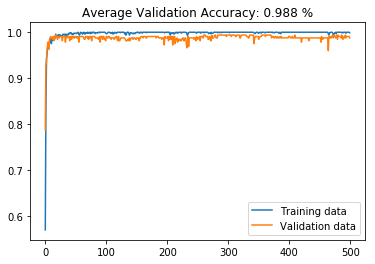

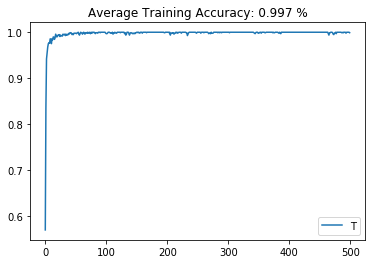

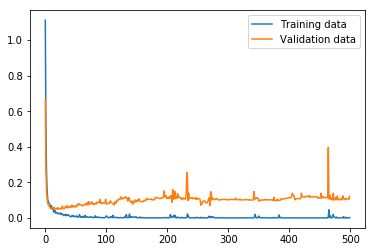

In [34]:
# Plotting
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Average Validation Accuracy: '+ str(round(np.mean(history.history['val_acc']),3 ) ) + ' %')
plt.legend(('Training data','Validation data'), loc='best')
plt.savefig('val_acc.eps', format='eps', dpi=1000)

plt.figure()
plt.plot(history.history['acc'])
plt.title('Average Training Accuracy: '+ str(round(np.mean(history.history['acc']),3 ) ) + ' %')
plt.legend(('Training data'), loc='best')
plt.savefig('val_acc.eps', format='eps', dpi=1000)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(('Training data','Validation data'), loc='best')


In [32]:
import datetime as dt
fn = 'saved_models/conv_history_'+ dt.datetime.now().strftime('%Y%m%d%H%M%S')+'.pkl'
with open(fn, 'wb') as handle:
    pickle.dump([history.params,history.history], handle, protocol=pickle.HIGHEST_PROTOCOL)
fn = 'saved_models/conv_model_'+ dt.datetime.now().strftime('%Y%m%d%H%M%S')+'.h5'
conv_model.save(fn)

In [51]:
# Loading the already saved model
conv_model_saved = load_model('saved_models/conv_model_20181018153911.h5')




with open('saved_models/conv_history_20181018153911.pkl', 'rb') as handle:
    saved_history = pickle.load(handle)

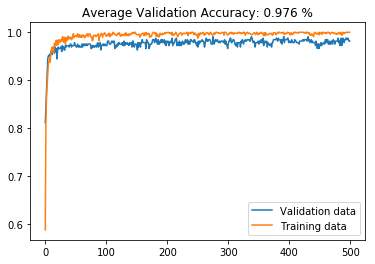

In [61]:
plt.figure()
plt.plot(saved_history[1]['val_acc'], label='Validation data')
plt.plot(saved_history[1]['acc'], label='Training data')
plt.title('Average Validation Accuracy: '+ str(round(np.mean(saved_history[1]['val_acc']),3 ) ) + ' %')
plt.legend(('Validation data', 'Training data'), loc='best')
plt.savefig('val_acc.eps', format='eps', dpi=1000)